In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from yellowbrick.regressor import residuals_plot
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from feature_engine.encoding import OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.metrics import mean_squared_error

In [2]:
pd.set_option("display.max_columns", 99)
df = pd.read_csv("../data/mergeA_for_modeling.csv")
df.head(n=3)


,Year,STNAM,FIPST,LEAID,LEANM,NCESSCH,SCHNAM,ALL_COHORT_,school_name,zip_mailing,zip_location,latitude,urban_centric_locale,county_code,school_level,school_type,lowest_grade_offered,highest_grade_offered,title_i_status,title_i_eligible,charter,magnet,virtual,teachers_fte,free_lunch,reduced_price_lunch,free_or_reduced_price_lunch,enrollment,ungrade_cedp,Math_Pct_Part,Rla_Pct_Part,ALL_RATE_
0,2012,ALASKA,2,200001,Lower Kuskokwim School District,20000100208,Bethel Regional High School,75,BETHEL REGIONAL HIGH SCHOOL,99559.0,99559.0,60.802584,41.0,2050.0,4.0,1.0,6.0,12.0,5.0,1.0,0.0,0.0,0.0,32.849998,210.0,28.0,238.0,506.0,0.0,97.5,97.5,52.0
1,2012,ALASKA,2,200001,Lower Kuskokwim School District,20000100318,Bethel Alternative Boarding School,28,BETHEL ALTERNATIVE BOARDING SCHOOL,99559.0,99559.0,60.795960,33.0,2050.0,3.0,4.0,8.0,12.0,5.0,1.0,0.0,0.0,0.0,4.000000,58.0,0.0,58.0,61.0,0.0,90.0,90.0,10.0
2,2012,ALASKA,2,200006,Mount Edgecumbe High School Agency,20000600558,Mt. Edgecumbe High School,71,MT. EDGECUMBE HIGH SCHOOL,99835.0,99835.0,57.051810,41.0,2220.0,3.0,1.0,9.0,12.0,5.0,1.0,0.0,0.0,0.0,22.500000,224.0,35.0,259.0,398.0,0.0,97.5,97.5,97.5


In [3]:
# Subset to columns that we believe have unique information in them; e.g. removing ID columns, names as strings
# Categoricals like LEAID, zip_location, and county_code like have some useful information but may have too many categories (1000s) to dummy encode.
# I am including the county_code in this test.
X = df.copy()
X.drop(["STNAM", "LEANM", "NCESSCH", "SCHNAM", "school_name", "zip_mailing",
       "LEAID", "zip_location"], inplace=True, axis=1)

y = X.pop("ALL_RATE_")

# Tag categoricals so that they can be treated properly by the modeling packages
numeric_cols = ["Rla_Pct_Part", "Math_Pct_Part", "enrollment", "free_lunch", "reduced_price_lunch", "free_or_reduced_price_lunch",
                "teachers_fte", "lowest_grade_offered", "highest_grade_offered", "latitude", "ALL_COHORT_", "Year"]
for col in numeric_cols:
    assert col in X.columns
categoricals = list(set(X.columns.tolist()) - set(numeric_cols))

# Convert categoricals to the pandas type 'category'
for col in categoricals:
    X[col] = X[col].astype("category")
X.dtypes

Year                              int64
FIPST                          category
ALL_COHORT_                       int64
latitude                        float64
urban_centric_locale           category
county_code                    category
school_level                   category
school_type                    category
lowest_grade_offered            float64
highest_grade_offered           float64
title_i_status                 category
title_i_eligible               category
charter                        category
magnet                         category
virtual                        category
teachers_fte                    float64
free_lunch                      float64
reduced_price_lunch             float64
free_or_reduced_price_lunch     float64
enrollment                      float64
ungrade_cedp                   category
Math_Pct_Part                   float64
Rla_Pct_Part                    float64
dtype: object

In [4]:
# Create train-test split
Xtrain0, Xtest0, ytrain0, ytest0 = train_test_split(
    X, y, test_size=0.25,stratify=y, random_state=42)

Xtrain=Xtrain0.copy()
ytrain = ytrain0.copy()
Xtest = Xtest0.copy()
ytest = ytest0.copy()
del Xtrain0, Xtest0, ytrain0, ytest0

In [5]:
Xtrain.head(n=2)


,Year,FIPST,ALL_COHORT_,latitude,urban_centric_locale,county_code,school_level,school_type,lowest_grade_offered,highest_grade_offered,title_i_status,title_i_eligible,charter,magnet,virtual,teachers_fte,free_lunch,reduced_price_lunch,free_or_reduced_price_lunch,enrollment,ungrade_cedp,Math_Pct_Part,Rla_Pct_Part
33884,2015,6,175,34.095930,21.0,6037.0,3.0,4.0,9.0,12.0,5.0,1.0,0.0,0.0,0.0,15.00,253.0,23.0,276.0,318.0,0.0,92.0,92.0
54097,2016,48,237,30.324213,11.0,48453.0,3.0,1.0,9.0,12.0,5.0,1.0,0.0,0.0,0.0,94.32,934.0,85.0,1019.0,1255.0,0.0,97.5,87.0


In [6]:
# Show our stratification on y. They have very similar distributions
print(ytrain.describe() - ytest.describe())
print(ytrain.describe() - df.ALL_RATE_.describe())


count    41828.000000
mean        -0.019808
std          0.020756
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.000000
Name: ALL_RATE_, dtype: float64
count   -20915.000000
mean        -0.004952
std          0.005301
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.000000
Name: ALL_RATE_, dtype: float64


# RandomForest Regression

In [7]:
# Create and run hyperparameter tuning pipeline
from sklearn.model_selection import GridSearchCV
clf = {}

scaler = SklearnTransformerWrapper(transformer=StandardScaler(),
                                    variables=numeric_cols)

In [8]:
import warnings
import joblib
import os
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
param_grid = {
    'rf__n_estimators': [250,350],
    'rf__max_features': [300,200],
    'rf__max_depth': [125,115],
    'rf__ccp_alpha': [0.0],
    'rf__random_state': [42],
}
pipe = Pipeline(steps=[("scaler", scaler), ("onehot", OneHotEncoder(drop_last=True, variables=categoricals)),
                        ("rf", RandomForestRegressor())])

# Load model from disk instead of running again.
# Running this job takes 64 minutes.
clf = {}
local_model_path = "../../student_outcome_saved_models/model_datasetA_random_forest_gridsearch1.pkl"
if os.path.exists(local_model_path):
    clf = joblib.load(local_model_path)
else:
    clf = GridSearchCV(pipe, param_grid, n_jobs=4, verbose=3,scoring='r2')
    clf.fit(Xtrain, ytrain)
    joblib.dump(clf, local_model_path)

* Tune parameters
* Run model on train and test and sets
*  Visualize
*  Feature Importance

In [9]:
# Print out best parameters
print(clf.best_params_)
clf.cv_results_
# For the n_estimators parameter, stepping up to 450 estimators did not improve the result at all.

# Two different methods are typical when optimizing trees: 
# a) Grid search on the max_depth parameter
# b) Select a high max_depth and gridsearch on the ccp_alpha penalization parameter (pruning).

{'rf__ccp_alpha': 0.0, 'rf__max_depth': 115, 'rf__max_features': 300, 'rf__n_estimators': 350, 'rf__random_state': 42}


{'mean_fit_time': array([289.03214579, 343.66941309, 208.75920587, 278.47878876,
        224.88768415, 354.96100936, 232.92468438, 304.00877919]),
 'std_fit_time': array([20.13172212, 27.98909598, 14.15642481, 10.55021459,  1.29834427,
        25.0147741 , 14.00441887, 19.85161568]),
 'mean_score_time': array([2.66008382, 2.86610146, 2.42639771, 3.04960427, 2.36008549,
        3.45615206, 2.63488169, 3.17884884]),
 'std_score_time': array([0.14528749, 0.08028129, 0.08959806, 0.09218736, 0.02826301,
        0.26618475, 0.22529946, 0.52486059]),
 'param_rf__ccp_alpha': masked_array(data=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_rf__max_depth': masked_array(data=[125, 125, 125, 125, 115, 115, 115, 115],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_rf__max_features

# Check best parameters on the test set

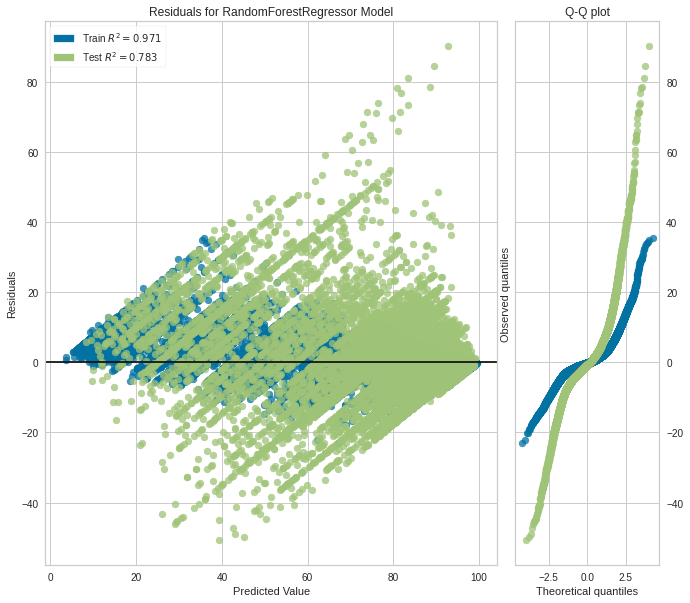

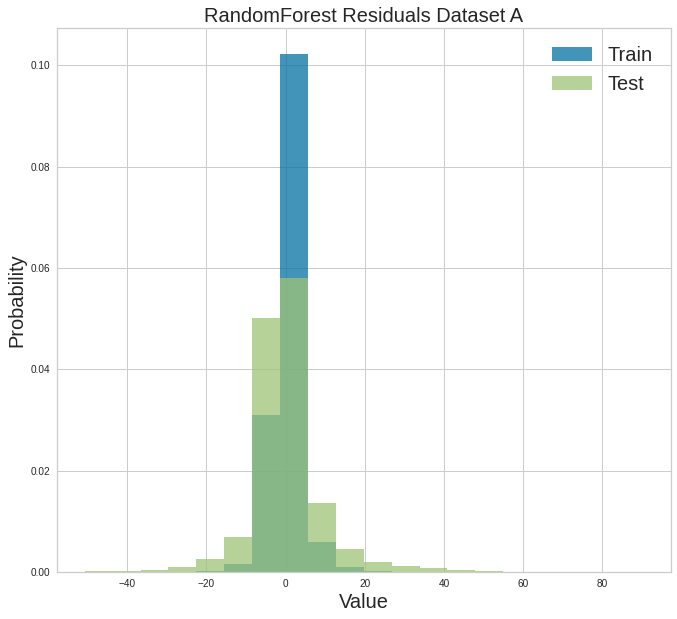

train rmsd =  3.321823206217733
train r2 =  0.9708197588121663
test rmsd =  9.045229008751104
test r2 =  0.7831713008172172


In [10]:
# Validate the best model on the train and test sets

# The fact that our residuals are far from normal suggests that we could improve our model.
# One idea is to add a polynomial_features to the model. Even though decision trees capture non-linearity,
# there is experience stated on StackOverflow that this can still improve performance.
pipe2 = Pipeline(steps=[("scaler", scaler), ("onehot", OneHotEncoder(drop_last=True, variables=categoricals)),
                            ("rf", RandomForestRegressor(n_jobs=4, n_estimators=350,max_features=300,max_depth=115))])
pipe2.fit(Xtrain,ytrain)
plt.rcParams["figure.figsize"] = (11, 10)
residuals_plot(pipe2, Xtrain, ytrain, Xtest, ytest, hist=False, qqplot=True)
plt.show()

from sklearn.metrics import r2_score
train_residuals = pipe2.predict(Xtrain) - ytrain
test_residuals = pipe2.predict(Xtest) - ytest

bins = np.histogram(np.hstack([train_residuals,test_residuals]),bins=20)[1]
plt.hist(train_residuals, density=True, alpha=0.75,bins=bins,label="Train")
plt.hist(test_residuals, density=True, alpha=0.75,bins=bins,label="Test")
plt.xlabel('Value',fontsize=20)
plt.ylabel('Probability',fontsize=20)
plt.title('RandomForest Residuals Dataset A',fontsize=20)
plt.legend(fontsize=20)
plt.show()
print("train rmsd = ", train_residuals.describe()[2])
print("train r2 = ", r2_score(ytrain, pipe2.predict(Xtrain)))
print("test rmsd = ", test_residuals.describe()[2])
print("test r2 = ", r2_score(ytest, pipe2.predict(Xtest)))


# Feature Importance


<BarContainer object of 65 artists>

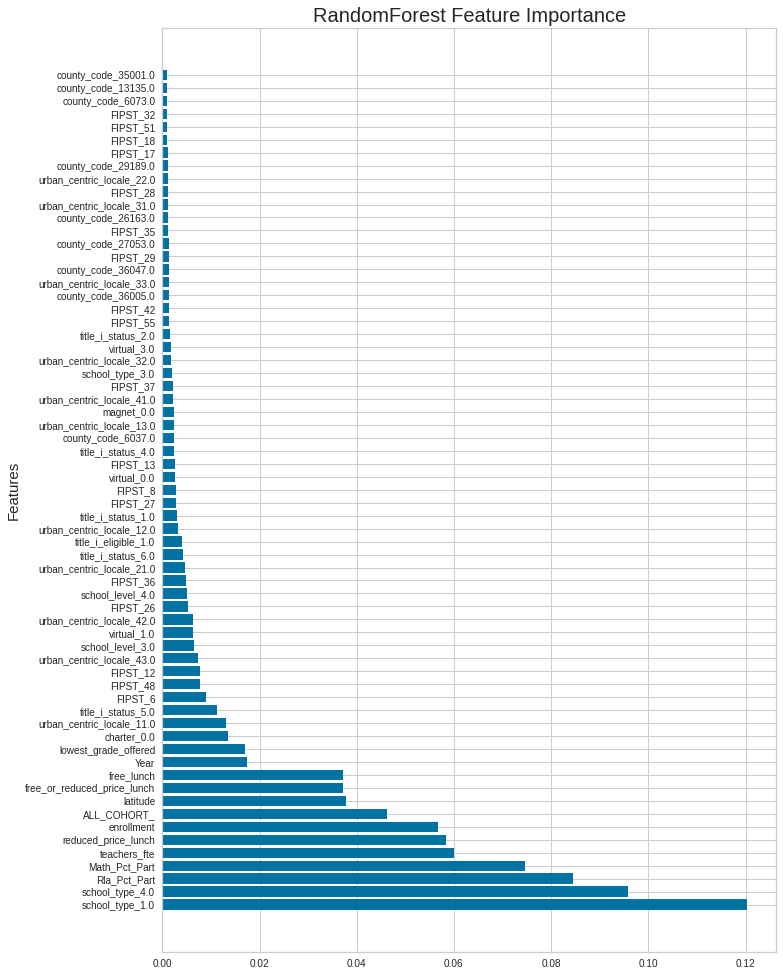

In [12]:
assert len(pipe2._final_estimator.feature_names_in_) == len(pipe2._final_estimator.feature_importances_)
feature_importances = list(zip(pipe2._final_estimator.feature_names_in_ , pipe2._final_estimator.feature_importances_))
sorted_features = sorted(feature_importances, key = lambda x: x[1],reverse=True)
names = [i[0] for i in sorted_features[:65]]
values = [i[1] for i in sorted_features[:65]]
plt.title("RandomForest Feature Importance",fontsize=20)
plt.rcParams["figure.figsize"] = (11, 17)
plt.ylabel(ylabel="Features",fontsize=15)
plt.barh(names,values)